In [2]:
import random
import torch
import numpy as np

def setup_seed(seed):
     torch.manual_seed(seed)
     torch.cuda.manual_seed_all(seed)
     np.random.seed(seed)
     random.seed(seed)
     torch.backends.cudnn.deterministic = True
# 设置随机数种子
setup_seed(3407)

# BAM

In [3]:
import dill

with open('dataloader\\train.pkl', 'rb') as f:
    trainloader = dill.load(f)
with open('dataloader\\test.pkl', 'rb') as f:
    testloader = dill.load(f)

In [4]:
from sklearn.model_selection import StratifiedKFold
from torch.autograd import Variable
import utils
from torch import nn, optim
from models import ResNet18, VGG
import transforms
import torch

use_cuda = torch.cuda.is_available()
opt = {
    "model": "ResNet101",
    "dataset": "all",
    "fold": 10,
    "train_bs": 64,
    "test_bs": 256,
    "val_bs": 256,
    "lr": 0.01,
    "resume": None,
}

best_Test_acc = 0  # best PrivateTest accuracy
best_Test_acc_epoch = 0
start_epoch = 0  # start from epoch 0 or last checkpoint epoch

learning_rate_decay_start = 20  # 50
learning_rate_decay_every = 1  # 5
learning_rate_decay_rate = 0.8  # 0.9

cut_size = 44
total_epoch = 60

In [5]:
import os

path = os.path.join(opt["dataset"] + '_' + opt["model"], str(opt["fold"]))

# Data
transform_train = transforms.Compose([
    transforms.RandomCrop(cut_size),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

transform_test = transforms.Compose([
    transforms.TenCrop(cut_size),
    transforms.Lambda(lambda crops: torch.stack([transforms.ToTensor()(crop) for crop in crops])),
])

In [6]:
import gc

gc.collect()

0

In [7]:
import os
from tqdm import tqdm


# Training
def train(epoch):
    print('\nEpoch: %d' % epoch)
    global Train_acc
    net.train()
    Train_loss = 0
    correct = 0
    total = 0

    if epoch > learning_rate_decay_start >= 0:
        frac = (epoch - learning_rate_decay_start) // learning_rate_decay_every
        decay_factor = learning_rate_decay_rate ** frac
        current_lr = opt["lr"] * decay_factor
        utils.set_lr(optimizer, current_lr)  # set the decayed rate
    else:
        current_lr = opt["lr"]
    print('learning_rate: %s' % str(current_lr))

    for inputs, targets in tqdm(trainloader):
        # print(batch_idx, (inputs, targets))
        if use_cuda:
            inputs, targets = inputs.cuda(), targets.cuda()
        # print(inputs, targets)
        optimizer.zero_grad()
        # print(optimizer)
        inputs, targets = Variable(inputs), Variable(targets)
        # print(inputs, targets)
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        utils.clip_gradient(optimizer, 0.1)
        optimizer.step()

        Train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum()

        # utils.progress_bar(batch_idx, len(trainloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)\n'
        #                    % (train_loss / (batch_idx + 1), 100. * correct / total, correct, total))

    Train_acc = 100. * correct / total
    return Train_loss, Train_acc, current_lr



In [8]:
import numpy as np


def test(epoch, all_predicted, all_targets, model_name):
    global Test_acc
    global best_Test_acc
    global best_Test_acc_epoch

    net.eval()
    Test_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in tqdm(enumerate(testloader)):
        bs, ncrops, c, h, w = np.shape(inputs)
        inputs = inputs.view(-1, c, h, w)

        if use_cuda:
            inputs, targets = inputs.cuda(), targets.cuda()
        with torch.no_grad():
            inputs, targets = Variable(inputs), Variable(targets)
        outputs = net(inputs)
        outputs_avg = outputs.view(bs, ncrops, -1).mean(1)  # avg over crops

        loss = criterion(outputs_avg, targets)
        Test_loss += loss.item()
        _, predicted = torch.max(outputs_avg.data, 1)
        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum()

        # utils.progress_bar(batch_idx, len(testloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)\n'
        #                    % (total_loss / (batch_idx + 1), 100. * correct / total, correct, total))

        if batch_idx == 0:
            temp_all_predicted = predicted
            temp_all_targets = targets
        else:
            temp_all_predicted = torch.cat((temp_all_predicted, predicted), 0)
            temp_all_targets = torch.cat((temp_all_targets, targets), 0)

    # Save checkpoint.
    Test_acc = 100. * correct / total

    if Test_acc > best_Test_acc:
        print('Saving..')
        print("best_Test_acc: %0.3f" % Test_acc)
        state = {'net': net.state_dict() if use_cuda else net,
                 'best_Test_acc': Test_acc,
                 'best_Test_acc_epoch': epoch,
                 }
        if not os.path.isdir(opt["dataset"] + '_' + opt["model"]):
            os.mkdir(opt["dataset"] + '_' + opt["model"])
        if not os.path.isdir(path):
            os.mkdir(path)
        torch.save(state, os.path.join(path, model_name))
        best_Test_acc = Test_acc
        best_Test_acc_epoch = epoch
        all_predicted = temp_all_predicted
        all_targets = temp_all_targets
        # print("test", all_predicted, all_targets)

    return all_predicted, all_targets, Test_loss, Test_acc


# def validate():
#     net.eval()
#     val_loss = 0
#     val_correct = 0
#     val_total = 0
#     with torch.no_grad():
#         for batch_idx, (inputs, targets) in enumerate(valloader):
#             bs, ncrops, c, h, w = np.shape(inputs)
#             inputs = inputs.view(-1, c, h, w)
#             if use_cuda:
#                 inputs, targets = inputs.cuda(), targets.cuda()
#
#             inputs, targets = Variable(inputs), Variable(targets)
#             outputs = net(inputs)
#             outputs_avg = outputs.view(bs, ncrops, -1).mean(1)  # avg over crops
#             loss = criterion(outputs_avg, targets)
#             val_loss += loss.item()
#             _, predicted = torch.max(outputs_avg.data, 1)
#             val_total += targets.size(0)
#             val_correct += predicted.eq(targets.data).cpu().sum()
#             # utils.progress_bar(batch_idx, len(valloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)\n'
#             #                    % (val_loss / (batch_idx + 1), 100. * val_correct / val_total, val_correct, val_total))
#     val_acc = 100. * val_correct / val_total
#     return val_loss, val_acc

In [9]:
from models import BAMAttention

net = BAMAttention.resnet101_BAM_attention(7)

In [10]:
net

ResNet101(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BAMBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bam): BAMAttentionBlock(
        (avg_pool): AdaptiveAvgPool2d(output_size=1)
        (fc1): Conv2d(64, 4, kernel_size=(1, 1), stride=(1, 1))
        (relu): ReLU()
        (fc2): Conv2d(4, 64, kernel_size=(1, 1), stride=(1, 1))
        (sigmoid): Sigmoid()
      )
      (shortcut): Identity()
    )
 

In [11]:
if opt["resume"]:
    # Load checkpoint.
    print('==> Resuming from checkpoint..')
    assert os.path.isdir(path), 'Error: no checkpoint directory found!'
    checkpoint = torch.load(os.path.join(path, 'Test_model.t7'))

    net.load_state_dict(checkpoint['net'])
    best_Test_acc = checkpoint['best_Test_acc']
    best_Test_acc_epoch = checkpoint['best_Test_acc_epoch']
    start_epoch = best_Test_acc_epoch + 1
else:
    print('==> Building model..')

if use_cuda:
    net.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=opt["lr"], momentum=0.9, weight_decay=5e-4)


==> Building model..


In [12]:
!wandb login "6843d78f9c143bc4eaa7f0f888f9cd6db7f063d2" --relogin

wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\dragon/.netrc


In [13]:
from PIL import Image

all_predicted = None
all_targets = None
import wandb

wandb.init(project="Face Expression Recognition", entity="face-expression-recognize")
for epoch in range(start_epoch, total_epoch):
    train_loss, train_acc, current_lr = train(epoch)
    all_predicted, all_targets, test_loss, test_acc = test(epoch=epoch, all_predicted=all_predicted,
                                                           all_targets=all_targets,
                                                           model_name="ResNet101 BAMAttention.pth")
    wandb.log({"Train Loss": train_loss,
               "Test Loss": test_loss,
               "Train Acc": train_acc,
               "Test Acc": test_acc,
               "Learning Rate": current_lr})
    # print(all_predicted, all_targets)

print("best_Test_acc: %0.3f" % best_Test_acc)
print("best_Test_acc_epoch: %d" % best_Test_acc_epoch)
wandb.finish()

wandb: Currently logged in as: aftermath0703 (face-expression-recognize). Use `wandb login --relogin` to force relogin



Epoch: 0
learning_rate: 0.01


  0%|          | 0/415 [00:00<?, ?it/s]E:\projects\Facial-Expression-Recognition\transforms\functional.py:63: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  img = torch.ByteTensor(torch.ByteStorage.from_buffer(pic.tobytes()))
100%|██████████| 415/415 [00:19<00:00, 21.72it/s]
15it [00:03,  4.22it/s]


Saving..
best_Test_acc: 43.567

Epoch: 1
learning_rate: 0.01


100%|██████████| 415/415 [00:15<00:00, 26.73it/s]
15it [00:03,  4.54it/s]


Saving..
best_Test_acc: 47.638

Epoch: 2
learning_rate: 0.01


100%|██████████| 415/415 [00:15<00:00, 27.10it/s]
15it [00:03,  4.50it/s]



Epoch: 3
learning_rate: 0.01


100%|██████████| 415/415 [00:15<00:00, 26.07it/s]
15it [00:03,  4.41it/s]


Saving..
best_Test_acc: 54.235

Epoch: 4
learning_rate: 0.01


100%|██████████| 415/415 [00:15<00:00, 27.00it/s]
15it [00:03,  4.53it/s]



Epoch: 5
learning_rate: 0.01


100%|██████████| 415/415 [00:15<00:00, 27.08it/s]
15it [00:03,  4.44it/s]


Saving..
best_Test_acc: 54.995

Epoch: 6
learning_rate: 0.01


100%|██████████| 415/415 [00:15<00:00, 27.02it/s]
15it [00:03,  4.48it/s]


Saving..
best_Test_acc: 56.352

Epoch: 7
learning_rate: 0.01


100%|██████████| 415/415 [00:15<00:00, 27.11it/s]
15it [00:03,  4.46it/s]



Epoch: 8
learning_rate: 0.01


100%|██████████| 415/415 [00:16<00:00, 25.54it/s]
15it [00:03,  4.41it/s]


Saving..
best_Test_acc: 59.121

Epoch: 9
learning_rate: 0.01


100%|██████████| 415/415 [00:15<00:00, 26.39it/s]
15it [00:03,  4.36it/s]


Saving..
best_Test_acc: 59.772

Epoch: 10
learning_rate: 0.01


100%|██████████| 415/415 [00:15<00:00, 25.98it/s]
15it [00:03,  4.34it/s]



Epoch: 11
learning_rate: 0.01


100%|██████████| 415/415 [00:15<00:00, 27.04it/s]
15it [00:03,  4.54it/s]



Epoch: 12
learning_rate: 0.01


100%|██████████| 415/415 [00:15<00:00, 26.74it/s]
15it [00:03,  4.45it/s]



Epoch: 13
learning_rate: 0.01


100%|██████████| 415/415 [00:23<00:00, 18.01it/s]
15it [00:06,  2.25it/s]



Epoch: 14
learning_rate: 0.01


100%|██████████| 415/415 [00:32<00:00, 12.67it/s]
15it [00:07,  2.04it/s]



Epoch: 15
learning_rate: 0.01


100%|██████████| 415/415 [00:32<00:00, 12.83it/s]
15it [00:07,  1.99it/s]


Saving..
best_Test_acc: 61.102

Epoch: 16
learning_rate: 0.01


100%|██████████| 415/415 [00:32<00:00, 12.84it/s]
15it [00:08,  1.83it/s]


Saving..
best_Test_acc: 61.482

Epoch: 17
learning_rate: 0.01


100%|██████████| 415/415 [00:32<00:00, 12.79it/s]
15it [00:08,  1.81it/s]



Epoch: 18
learning_rate: 0.01


100%|██████████| 415/415 [00:32<00:00, 12.74it/s]
15it [00:08,  1.86it/s]



Epoch: 19
learning_rate: 0.01


100%|██████████| 415/415 [00:32<00:00, 12.69it/s]
15it [00:07,  2.00it/s]



Epoch: 20
learning_rate: 0.01


100%|██████████| 415/415 [00:32<00:00, 12.80it/s]
15it [00:06,  2.22it/s]



Epoch: 21
learning_rate: 0.008


100%|██████████| 415/415 [00:32<00:00, 12.86it/s]
15it [00:06,  2.22it/s]


Saving..
best_Test_acc: 62.568

Epoch: 22
learning_rate: 0.006400000000000001


100%|██████████| 415/415 [00:32<00:00, 12.73it/s]
15it [00:06,  2.24it/s]


Saving..
best_Test_acc: 62.975

Epoch: 23
learning_rate: 0.005120000000000001


100%|██████████| 415/415 [00:32<00:00, 12.82it/s]
15it [00:06,  2.41it/s]


Saving..
best_Test_acc: 63.328

Epoch: 24
learning_rate: 0.004096000000000001


100%|██████████| 415/415 [00:32<00:00, 12.78it/s]
15it [00:06,  2.49it/s]


Saving..
best_Test_acc: 64.712

Epoch: 25
learning_rate: 0.0032768000000000007


100%|██████████| 415/415 [00:32<00:00, 12.89it/s]
15it [00:06,  2.48it/s]


Saving..
best_Test_acc: 64.875

Epoch: 26
learning_rate: 0.002621440000000001


100%|██████████| 415/415 [00:32<00:00, 12.62it/s]
15it [00:06,  2.49it/s]


Saving..
best_Test_acc: 65.554

Epoch: 27
learning_rate: 0.002097152000000001


100%|██████████| 415/415 [00:32<00:00, 12.88it/s]
15it [00:06,  2.49it/s]


Saving..
best_Test_acc: 65.907

Epoch: 28
learning_rate: 0.001677721600000001


100%|██████████| 415/415 [00:32<00:00, 12.84it/s]
15it [00:06,  2.47it/s]



Epoch: 29
learning_rate: 0.0013421772800000006


100%|██████████| 415/415 [00:32<00:00, 12.88it/s]
15it [00:06,  2.29it/s]


Saving..
best_Test_acc: 66.422

Epoch: 30
learning_rate: 0.0010737418240000006


100%|██████████| 415/415 [00:32<00:00, 12.88it/s]
15it [00:05,  2.51it/s]


Saving..
best_Test_acc: 66.504

Epoch: 31
learning_rate: 0.0008589934592000006


100%|██████████| 415/415 [00:32<00:00, 12.86it/s]
15it [00:06,  2.49it/s]


Saving..
best_Test_acc: 66.667

Epoch: 32
learning_rate: 0.0006871947673600004


100%|██████████| 415/415 [00:32<00:00, 12.81it/s]
15it [00:06,  2.47it/s]



Epoch: 33
learning_rate: 0.0005497558138880004


100%|██████████| 415/415 [00:33<00:00, 12.52it/s]
15it [00:06,  2.45it/s]



Epoch: 34
learning_rate: 0.00043980465111040037


100%|██████████| 415/415 [00:32<00:00, 12.73it/s]
15it [00:06,  2.48it/s]


Saving..
best_Test_acc: 66.775

Epoch: 35
learning_rate: 0.0003518437208883203


100%|██████████| 415/415 [00:32<00:00, 12.73it/s]
15it [00:06,  2.46it/s]



Epoch: 36
learning_rate: 0.00028147497671065624


100%|██████████| 415/415 [00:33<00:00, 12.53it/s]
15it [00:06,  2.46it/s]



Epoch: 37
learning_rate: 0.00022517998136852504


100%|██████████| 415/415 [00:32<00:00, 12.76it/s]
15it [00:06,  2.44it/s]



Epoch: 38
learning_rate: 0.00018014398509482002


100%|██████████| 415/415 [00:32<00:00, 12.75it/s]
15it [00:06,  2.48it/s]



Epoch: 39
learning_rate: 0.00014411518807585602


100%|██████████| 415/415 [00:32<00:00, 12.76it/s]
15it [00:06,  2.48it/s]



Epoch: 40
learning_rate: 0.00011529215046068484


100%|██████████| 415/415 [00:33<00:00, 12.52it/s]
15it [00:06,  2.46it/s]



Epoch: 41
learning_rate: 9.223372036854788e-05


100%|██████████| 415/415 [00:32<00:00, 12.72it/s]
15it [00:06,  2.47it/s]



Epoch: 42
learning_rate: 7.37869762948383e-05


100%|██████████| 415/415 [00:32<00:00, 12.75it/s]
15it [00:06,  2.50it/s]



Epoch: 43
learning_rate: 5.902958103587064e-05


100%|██████████| 415/415 [00:33<00:00, 12.53it/s]
15it [00:06,  2.46it/s]



Epoch: 44
learning_rate: 4.722366482869652e-05


100%|██████████| 415/415 [00:32<00:00, 12.76it/s]
15it [00:06,  2.46it/s]



Epoch: 45
learning_rate: 3.777893186295722e-05


100%|██████████| 415/415 [00:32<00:00, 12.74it/s]
15it [00:06,  2.44it/s]



Epoch: 46
learning_rate: 3.0223145490365776e-05


100%|██████████| 415/415 [00:32<00:00, 12.74it/s]
15it [00:06,  2.47it/s]



Epoch: 47
learning_rate: 2.417851639229262e-05


100%|██████████| 415/415 [00:34<00:00, 12.16it/s]
15it [00:06,  2.49it/s]



Epoch: 48
learning_rate: 1.9342813113834096e-05


100%|██████████| 415/415 [00:23<00:00, 17.78it/s]
15it [00:03,  4.50it/s]



Epoch: 49
learning_rate: 1.547425049106728e-05


100%|██████████| 415/415 [00:19<00:00, 21.12it/s]
15it [00:08,  1.78it/s]



Epoch: 50
learning_rate: 1.2379400392853824e-05


100%|██████████| 415/415 [00:32<00:00, 12.76it/s]
15it [00:06,  2.28it/s]



Epoch: 51
learning_rate: 9.903520314283058e-06


100%|██████████| 415/415 [00:32<00:00, 12.66it/s]
15it [00:06,  2.26it/s]



Epoch: 52
learning_rate: 7.922816251426448e-06


100%|██████████| 415/415 [00:33<00:00, 12.48it/s]
15it [00:06,  2.22it/s]



Epoch: 53
learning_rate: 6.338253001141158e-06


100%|██████████| 415/415 [00:32<00:00, 12.63it/s]
15it [00:06,  2.47it/s]



Epoch: 54
learning_rate: 5.0706024009129275e-06


100%|██████████| 415/415 [00:33<00:00, 12.38it/s]
15it [00:06,  2.45it/s]



Epoch: 55
learning_rate: 4.056481920730342e-06


100%|██████████| 415/415 [00:32<00:00, 12.63it/s]
15it [00:06,  2.46it/s]



Epoch: 56
learning_rate: 3.2451855365842735e-06


100%|██████████| 415/415 [00:32<00:00, 12.61it/s]
15it [00:06,  2.47it/s]



Epoch: 57
learning_rate: 2.5961484292674196e-06


100%|██████████| 415/415 [00:33<00:00, 12.39it/s]
15it [00:06,  2.45it/s]



Epoch: 58
learning_rate: 2.0769187434139356e-06


100%|██████████| 415/415 [00:32<00:00, 12.64it/s]
15it [00:06,  2.47it/s]



Epoch: 59
learning_rate: 1.6615349947311485e-06


100%|██████████| 415/415 [00:32<00:00, 12.59it/s]
15it [00:06,  2.32it/s]

best_Test_acc: 66.775
best_Test_acc_epoch: 34


Learning Rate,██████████████▇▅▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Test Acc,▁▂▄▄▅▅▆▅▅▅▆▆▆▆▇▇▇▇██████████████████████
Test Loss,█▆▄▄▄▃▂▃▃▄▂▁▂▂▁▁▁▁▁▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▄▄▄▄▄▄
Train Acc,▁▂▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▇▇▇▇██████████████████
Train Loss,█▇▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Learning Rate,0.0
Test Acc,66.61238
Test Loss,17.80893
Train Acc,94.75211
Train Loss,65.36344


In [14]:
import itertools
from matplotlib import pyplot as plt


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=16)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=18)
    plt.xlabel('Predicted label', fontsize=18)
    plt.tight_layout()

Normalized confusion matrix
[[0.62 0.01 0.09 0.05 0.1  0.12 0.02]
 [0.18 0.65 0.06 0.01 0.01 0.06 0.03]
 [0.1  0.   0.47 0.04 0.12 0.19 0.08]
 [0.01 0.   0.02 0.87 0.06 0.04 0.01]
 [0.07 0.   0.05 0.07 0.6  0.18 0.02]
 [0.08 0.   0.12 0.06 0.17 0.55 0.02]
 [0.03 0.   0.06 0.04 0.04 0.02 0.81]]


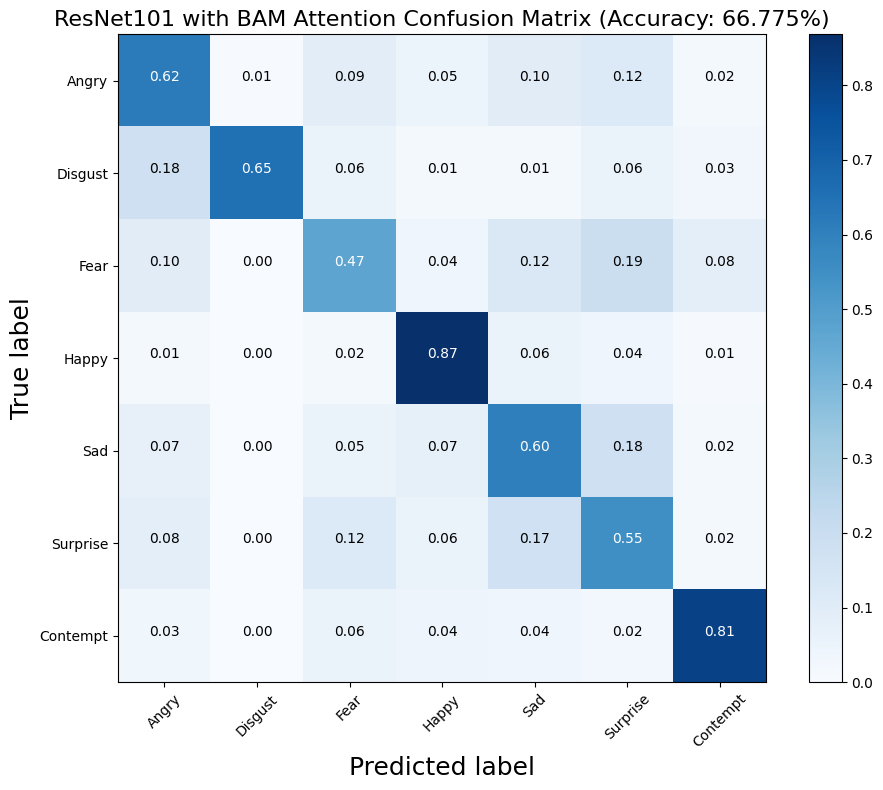

In [15]:
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix

class_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Contempt']

# Compute confusion matrix
matrix = confusion_matrix(all_targets.data.cpu().numpy(), all_predicted.cpu().numpy())
np.set_printoptions(precision=2)

# Plot normalized confusion matrix
plt.figure(figsize=(10, 8))
plot_confusion_matrix(matrix, classes=class_names, normalize=True,
                      title='ResNet101 with BAM Attention Confusion Matrix (Accuracy: %0.3f%%)' % best_Test_acc)
plt.show()
plt.savefig(os.path.join(opt["dataset"] + '_' + opt["model"], 'ResNet101 with BAMAttention Confusion Matrix.png'))
plt.close()

# CBAM

In [16]:
from sklearn.model_selection import StratifiedKFold
from torch.autograd import Variable
import utils
from torch import nn, optim
from models import ResNet18, VGG
import transforms
import torch

use_cuda = torch.cuda.is_available()
opt = {
    "model": "ResNet101",
    "dataset": "all",
    "fold": 10,
    "train_bs": 64,
    "test_bs": 256,
    "val_bs": 256,
    "lr": 0.01,
    "resume": None,
}

best_Test_acc = 0  # best PrivateTest accuracy
best_Test_acc_epoch = 0
start_epoch = 0  # start from epoch 0 or last checkpoint epoch

learning_rate_decay_start = 20  # 50
learning_rate_decay_every = 1  # 5
learning_rate_decay_rate = 0.8  # 0.9

cut_size = 44
total_epoch = 60

In [17]:
import gc
del net
gc.collect()

9266

In [18]:
from models import CBAMAttention

net = CBAMAttention.resnet101_CBAM_attention(7)
net

ResNet101(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): CBAMBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (cbam): CBAMAttentionBlock(
        (channel_attention): ChannelAttention(
          (avg_pool): AdaptiveAvgPool2d(output_size=1)
          (max_pool): AdaptiveMaxPool2d(output_size=1)
          (fc1): Conv2d(64, 4, kernel_size=(1, 1), stride=(1, 1))
          (relu): ReLU()
          (fc2): Conv2d(4,

In [19]:
if opt["resume"]:
    # Load checkpoint.
    print('==> Resuming from checkpoint..')
    assert os.path.isdir(path), 'Error: no checkpoint directory found!'
    checkpoint = torch.load(os.path.join(path, 'Test_model.t7'))

    net.load_state_dict(checkpoint['net'])
    best_Test_acc = checkpoint['best_Test_acc']
    best_Test_acc_epoch = checkpoint['best_Test_acc_epoch']
    start_epoch = best_Test_acc_epoch + 1
else:
    print('==> Building model..')

if use_cuda:
    net.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=opt["lr"], momentum=0.9, weight_decay=5e-4)


==> Building model..


In [20]:
all_predicted = None
all_targets = None
import wandb

wandb.init(project="Face Expression Recognition", entity="aftermath0703")
for epoch in range(start_epoch, total_epoch):
    train_loss, train_acc, current_lr = train(epoch)
    all_predicted, all_targets, test_loss, test_acc = test(epoch=epoch, all_predicted=all_predicted,
                                                           all_targets=all_targets,
                                                           model_name="ResNet101 CBAMAttention.pth")
    wandb.log({"Train Loss": train_loss,
               "Test Loss": test_loss,
               "Train Acc": train_acc,
               "Test Acc": test_acc,
               "Learning Rate": current_lr})
    # print(all_predicted, all_targets)

print("best_Test_acc: %0.3f" % best_Test_acc)
print("best_Test_acc_epoch: %d" % best_Test_acc_epoch)
wandb.finish()

wandb: Currently logged in as: aftermath0703. Use `wandb login --relogin` to force relogin



Epoch: 0
learning_rate: 0.01


100%|██████████| 415/415 [00:46<00:00,  8.84it/s]
15it [00:06,  2.44it/s]


Saving..
best_Test_acc: 22.828

Epoch: 1
learning_rate: 0.01


100%|██████████| 415/415 [00:47<00:00,  8.77it/s]
15it [00:06,  2.44it/s]


Saving..
best_Test_acc: 46.308

Epoch: 2
learning_rate: 0.01


100%|██████████| 415/415 [00:46<00:00,  8.85it/s]
15it [00:06,  2.38it/s]


Saving..
best_Test_acc: 51.059

Epoch: 3
learning_rate: 0.01


100%|██████████| 415/415 [00:47<00:00,  8.72it/s]
15it [00:06,  2.42it/s]


Saving..
best_Test_acc: 53.990

Epoch: 4
learning_rate: 0.01


100%|██████████| 415/415 [00:46<00:00,  8.90it/s]
15it [00:06,  2.46it/s]



Epoch: 5
learning_rate: 0.01


100%|██████████| 415/415 [00:47<00:00,  8.78it/s]
15it [00:06,  2.45it/s]


Saving..
best_Test_acc: 57.546

Epoch: 6
learning_rate: 0.01


100%|██████████| 415/415 [00:46<00:00,  8.88it/s]
15it [00:06,  2.43it/s]


Saving..
best_Test_acc: 59.066

Epoch: 7
learning_rate: 0.01


100%|██████████| 415/415 [00:47<00:00,  8.76it/s]
15it [00:06,  2.40it/s]



Epoch: 8
learning_rate: 0.01


100%|██████████| 415/415 [00:47<00:00,  8.80it/s]
15it [00:06,  2.44it/s]



Epoch: 9
learning_rate: 0.01


100%|██████████| 415/415 [00:47<00:00,  8.70it/s]
15it [00:06,  2.41it/s]



Epoch: 10
learning_rate: 0.01


100%|██████████| 415/415 [00:47<00:00,  8.82it/s]
15it [00:06,  2.43it/s]



Epoch: 11
learning_rate: 0.01


100%|██████████| 415/415 [00:47<00:00,  8.71it/s]
15it [00:06,  2.41it/s]


Saving..
best_Test_acc: 59.663

Epoch: 12
learning_rate: 0.01


100%|██████████| 415/415 [00:47<00:00,  8.70it/s]
15it [00:06,  2.40it/s]


Saving..
best_Test_acc: 62.405

Epoch: 13
learning_rate: 0.01


100%|██████████| 415/415 [00:47<00:00,  8.79it/s]
15it [00:06,  2.42it/s]



Epoch: 14
learning_rate: 0.01


100%|██████████| 415/415 [00:47<00:00,  8.70it/s]
15it [00:06,  2.40it/s]



Epoch: 15
learning_rate: 0.01


100%|██████████| 415/415 [00:47<00:00,  8.81it/s]
15it [00:06,  2.40it/s]



Epoch: 16
learning_rate: 0.01


100%|██████████| 415/415 [00:47<00:00,  8.70it/s]
15it [00:06,  2.40it/s]



Epoch: 17
learning_rate: 0.01


100%|██████████| 415/415 [00:47<00:00,  8.73it/s]
15it [00:06,  2.41it/s]



Epoch: 18
learning_rate: 0.01


100%|██████████| 415/415 [00:47<00:00,  8.70it/s]
15it [00:06,  2.41it/s]



Epoch: 19
learning_rate: 0.01


100%|██████████| 415/415 [00:47<00:00,  8.80it/s]
15it [00:06,  2.18it/s]



Epoch: 20
learning_rate: 0.01


100%|██████████| 415/415 [00:47<00:00,  8.81it/s]
15it [00:06,  2.41it/s]



Epoch: 21
learning_rate: 0.008


100%|██████████| 415/415 [00:46<00:00,  8.95it/s]
15it [00:03,  4.22it/s]



Epoch: 22
learning_rate: 0.006400000000000001


100%|██████████| 415/415 [00:22<00:00, 18.80it/s]
15it [00:03,  4.21it/s]


Saving..
best_Test_acc: 63.572

Epoch: 23
learning_rate: 0.005120000000000001


100%|██████████| 415/415 [00:21<00:00, 18.98it/s]
15it [00:03,  4.24it/s]


Saving..
best_Test_acc: 65.499

Epoch: 24
learning_rate: 0.004096000000000001


100%|██████████| 415/415 [00:21<00:00, 18.93it/s]
15it [00:03,  4.23it/s]



Epoch: 25
learning_rate: 0.0032768000000000007


100%|██████████| 415/415 [00:21<00:00, 19.00it/s]
15it [00:03,  4.23it/s]



Epoch: 26
learning_rate: 0.002621440000000001


100%|██████████| 415/415 [00:21<00:00, 19.04it/s]
15it [00:03,  4.22it/s]


Saving..
best_Test_acc: 66.069

Epoch: 27
learning_rate: 0.002097152000000001


100%|██████████| 415/415 [00:21<00:00, 19.01it/s]
15it [00:03,  4.18it/s]



Epoch: 28
learning_rate: 0.001677721600000001


100%|██████████| 415/415 [00:21<00:00, 19.12it/s]
15it [00:03,  4.22it/s]



Epoch: 29
learning_rate: 0.0013421772800000006


100%|██████████| 415/415 [00:21<00:00, 19.14it/s]
15it [00:03,  4.24it/s]


Saving..
best_Test_acc: 66.667

Epoch: 30
learning_rate: 0.0010737418240000006


100%|██████████| 415/415 [00:21<00:00, 19.01it/s]
15it [00:03,  4.15it/s]



Epoch: 31
learning_rate: 0.0008589934592000006


100%|██████████| 415/415 [00:22<00:00, 18.75it/s]
15it [00:03,  4.20it/s]



Epoch: 32
learning_rate: 0.0006871947673600004


100%|██████████| 415/415 [00:21<00:00, 18.88it/s]
15it [00:03,  4.18it/s]


Saving..
best_Test_acc: 66.748

Epoch: 33
learning_rate: 0.0005497558138880004


100%|██████████| 415/415 [00:21<00:00, 18.97it/s]
15it [00:03,  4.15it/s]



Epoch: 34
learning_rate: 0.00043980465111040037


100%|██████████| 415/415 [00:21<00:00, 19.02it/s]
15it [00:03,  4.21it/s]



Epoch: 35
learning_rate: 0.0003518437208883203


100%|██████████| 415/415 [00:21<00:00, 19.04it/s]
15it [00:03,  4.16it/s]



Epoch: 36
learning_rate: 0.00028147497671065624


100%|██████████| 415/415 [00:22<00:00, 18.41it/s]
15it [00:03,  4.21it/s]



Epoch: 37
learning_rate: 0.00022517998136852504


100%|██████████| 415/415 [00:21<00:00, 19.00it/s]
15it [00:03,  4.20it/s]



Epoch: 38
learning_rate: 0.00018014398509482002


100%|██████████| 415/415 [00:21<00:00, 19.02it/s]
15it [00:03,  4.18it/s]


Saving..
best_Test_acc: 67.047

Epoch: 39
learning_rate: 0.00014411518807585602


100%|██████████| 415/415 [00:21<00:00, 18.90it/s]
15it [00:03,  4.21it/s]


Saving..
best_Test_acc: 67.237

Epoch: 40
learning_rate: 0.00011529215046068484


100%|██████████| 415/415 [00:21<00:00, 18.96it/s]
15it [00:03,  4.21it/s]



Epoch: 41
learning_rate: 9.223372036854788e-05


100%|██████████| 415/415 [00:21<00:00, 19.06it/s]
15it [00:03,  4.15it/s]



Epoch: 42
learning_rate: 7.37869762948383e-05


100%|██████████| 415/415 [00:21<00:00, 18.96it/s]
15it [00:03,  4.20it/s]



Epoch: 43
learning_rate: 5.902958103587064e-05


100%|██████████| 415/415 [00:21<00:00, 19.08it/s]
15it [00:03,  4.23it/s]



Epoch: 44
learning_rate: 4.722366482869652e-05


100%|██████████| 415/415 [00:21<00:00, 19.12it/s]
15it [00:03,  4.13it/s]



Epoch: 45
learning_rate: 3.777893186295722e-05


100%|██████████| 415/415 [00:21<00:00, 19.03it/s]
15it [00:03,  4.21it/s]



Epoch: 46
learning_rate: 3.0223145490365776e-05


100%|██████████| 415/415 [00:21<00:00, 18.94it/s]
15it [00:03,  4.14it/s]



Epoch: 47
learning_rate: 2.417851639229262e-05


100%|██████████| 415/415 [00:21<00:00, 19.07it/s]
15it [00:03,  4.24it/s]



Epoch: 48
learning_rate: 1.9342813113834096e-05


100%|██████████| 415/415 [00:21<00:00, 18.92it/s]
15it [00:03,  4.21it/s]



Epoch: 49
learning_rate: 1.547425049106728e-05


100%|██████████| 415/415 [00:21<00:00, 18.97it/s]
15it [00:03,  4.18it/s]



Epoch: 50
learning_rate: 1.2379400392853824e-05


100%|██████████| 415/415 [00:21<00:00, 19.05it/s]
15it [00:03,  4.17it/s]



Epoch: 51
learning_rate: 9.903520314283058e-06


100%|██████████| 415/415 [00:21<00:00, 19.01it/s]
15it [00:03,  4.25it/s]



Epoch: 52
learning_rate: 7.922816251426448e-06


100%|██████████| 415/415 [00:21<00:00, 19.01it/s]
15it [00:03,  4.23it/s]



Epoch: 53
learning_rate: 6.338253001141158e-06


100%|██████████| 415/415 [00:21<00:00, 19.11it/s]
15it [00:03,  4.21it/s]



Epoch: 54
learning_rate: 5.0706024009129275e-06


100%|██████████| 415/415 [00:21<00:00, 18.98it/s]
15it [00:03,  4.19it/s]



Epoch: 55
learning_rate: 4.056481920730342e-06


100%|██████████| 415/415 [00:22<00:00, 18.36it/s]
15it [00:03,  4.24it/s]



Epoch: 56
learning_rate: 3.2451855365842735e-06


100%|██████████| 415/415 [00:21<00:00, 19.07it/s]
15it [00:03,  4.15it/s]



Epoch: 57
learning_rate: 2.5961484292674196e-06


100%|██████████| 415/415 [00:21<00:00, 19.12it/s]
15it [00:03,  4.20it/s]



Epoch: 58
learning_rate: 2.0769187434139356e-06


100%|██████████| 415/415 [00:21<00:00, 19.04it/s]
15it [00:03,  4.13it/s]



Epoch: 59
learning_rate: 1.6615349947311485e-06


100%|██████████| 415/415 [00:21<00:00, 19.05it/s]
15it [00:03,  4.18it/s]

best_Test_acc: 67.237
best_Test_acc_epoch: 39


Learning Rate,██████████████▇▅▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Test Acc,▁▅▆▆▇▇▇▆▇▇▆▇▆▅▇▇████████████████████████
Test Loss,█▃▃▂▂▂▂▂▁▁▂▁▂▃▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃
Train Acc,▁▂▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▇▇▇▇███████████████████
Train Loss,█▇▆▆▆▅▅▅▅▅▅▄▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Learning Rate,0.0
Test Acc,66.66666
Test Loss,19.84895
Train Acc,96.91079
Train Loss,37.49591


Normalized confusion matrix
[[0.61 0.   0.07 0.05 0.11 0.14 0.02]
 [0.14 0.68 0.04 0.03 0.03 0.06 0.03]
 [0.1  0.   0.47 0.03 0.12 0.21 0.07]
 [0.02 0.   0.01 0.87 0.05 0.04 0.01]
 [0.07 0.   0.04 0.08 0.62 0.18 0.01]
 [0.08 0.   0.12 0.06 0.15 0.57 0.01]
 [0.02 0.   0.07 0.04 0.04 0.03 0.8 ]]


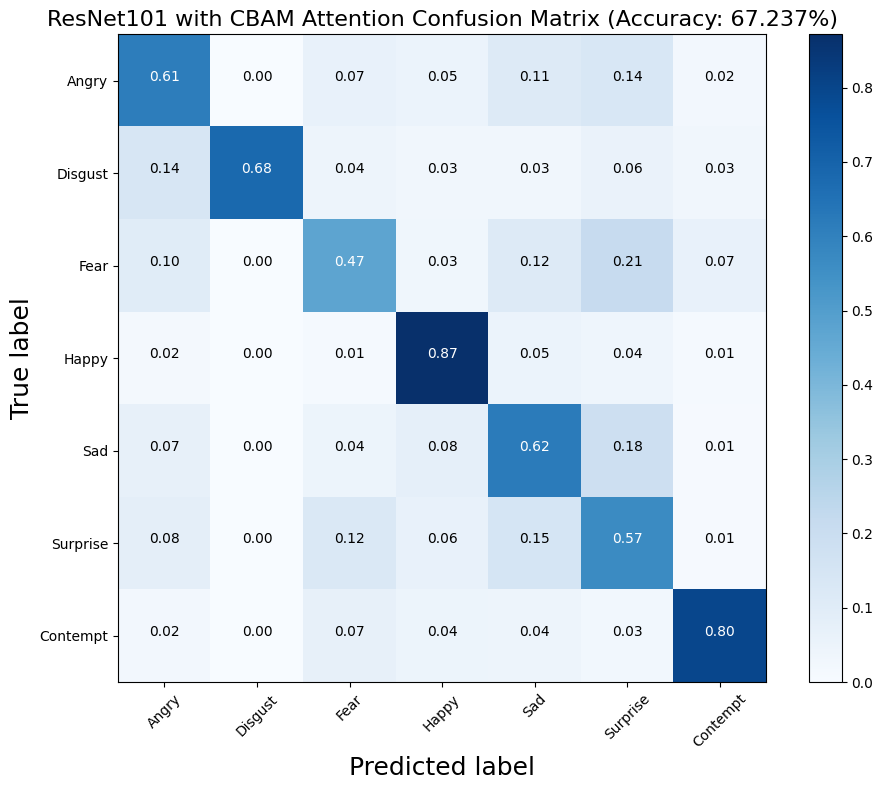

In [21]:
import itertools
from matplotlib import pyplot as plt


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=16)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=18)
    plt.xlabel('Predicted label', fontsize=18)
    plt.tight_layout()


from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix

class_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Contempt']

# Compute confusion matrix
matrix = confusion_matrix(all_targets.data.cpu().numpy(), all_predicted.cpu().numpy())
np.set_printoptions(precision=2)

# Plot normalized confusion matrix
plt.figure(figsize=(10, 8))
plot_confusion_matrix(matrix, classes=class_names, normalize=True,
                      title='ResNet101 with CBAM Attention Confusion Matrix (Accuracy: %0.3f%%)' % best_Test_acc)
plt.show()
plt.savefig(os.path.join(opt["dataset"] + '_' + opt["model"], 'ResNet101 with CBAMAttention Confusion Matrix.png'))
plt.close()